# Data Diri

Nama: Sahrial Ihsani Ishak

Asal: Bengkulu

# Code



Dataset: https://www.kaggle.com/jonathanoheix/face-expression-recognition-datasetinsects-recognition

Face expression Recognition with CNN

In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sahrialihsaniishak","key":"1cd8c1d5abed5608434908e6b1d8d093"}'}

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset
!ls

 85% 103M/121M [00:00<00:00, 252MB/s] 
100% 121M/121M [00:00<00:00, 223MB/s]
face-expression-recognition-dataset.zip  kaggle.json  sample_data


In [5]:
#Import Library
import zipfile
import os
import shutil
from sklearn.model_selection import train_test_split 
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.layers import Dense,Input,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam

In [6]:
# Ekstraksi pada file zip sebelumnya
local_zip = '/content/face-expression-recognition-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
train_folder= '/content/images/train'
os.listdir(train_folder)

['neutral', 'surprise', 'fear', 'disgust', 'angry', 'happy', 'sad']

In [8]:
validation_folder= '/content/images/validation'
os.listdir(validation_folder)

['neutral', 'surprise', 'fear', 'disgust', 'angry', 'happy', 'sad']

In [9]:
#Augmentasi and generate images
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [10]:
#Preprocessing data with generator
train_generator = train_datagen.flow_from_directory(
        train_folder,  
        target_size=(48, 48), 
        batch_size=64,
        color_mode='grayscale',
        class_mode='categorical',
        shuffle=True)
validation_generator = test_datagen.flow_from_directory(
        validation_folder, 
        target_size=(48, 48),  
        batch_size=64, 
        color_mode='grayscale',
        class_mode='categorical',
        shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [11]:
#CNN Architecture Model sequentials (Maxpooling and convolutional layer), flatten to make single array

model = tf.keras.models.Sequential([
    #Layer1
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',kernel_initializer='he_uniform', padding='same',input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    #Layer2
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Layer3
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Layer4
    tf.keras.layers.Conv2D(512, (3,3), activation='relu',kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    #Fully Connected Layer
    tf.keras.layers.Dense(1024, activation='relu',kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(7, activation='softmax')
])


In [12]:
#Optimizer with adam
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=1.0000e-04),
              metrics=['accuracy'])

In [13]:
#Callback untuk mencegah overfitting dengan menghentikan training, apabila telah terpenuhi
class reduceOverfitting(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.98):
      print("\nStopped! Akurasi sudah mencapai 98%")
      self.model.stop_training = True
stop = reduceOverfitting()

In [14]:
#see the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 512)         1

In [15]:
#train our model with callback to reduce overfitting 
trainmodel = model.fit(
    train_generator,
    steps_per_epoch = 451, 
    epochs = 200,
    validation_data = validation_generator,
    validation_steps = 110, 
    verbose =2,       
      callbacks=[stop] 
)

Epoch 1/200
451/451 - 50s - loss: 1.8230 - accuracy: 0.2460 - val_loss: 1.7610 - val_accuracy: 0.2866
Epoch 2/200
451/451 - 18s - loss: 1.7567 - accuracy: 0.2823 - val_loss: 1.7011 - val_accuracy: 0.3247
Epoch 3/200
451/451 - 18s - loss: 1.6942 - accuracy: 0.3223 - val_loss: 1.6661 - val_accuracy: 0.3455
Epoch 4/200
451/451 - 18s - loss: 1.6316 - accuracy: 0.3591 - val_loss: 1.5539 - val_accuracy: 0.4024
Epoch 5/200
451/451 - 18s - loss: 1.5724 - accuracy: 0.3883 - val_loss: 1.5263 - val_accuracy: 0.4216
Epoch 6/200
451/451 - 18s - loss: 1.5241 - accuracy: 0.4125 - val_loss: 1.4730 - val_accuracy: 0.4277
Epoch 7/200
451/451 - 18s - loss: 1.4844 - accuracy: 0.4291 - val_loss: 1.4249 - val_accuracy: 0.4626
Epoch 8/200
451/451 - 18s - loss: 1.4581 - accuracy: 0.4409 - val_loss: 1.4215 - val_accuracy: 0.4638
Epoch 9/200
451/451 - 18s - loss: 1.4248 - accuracy: 0.4554 - val_loss: 1.3792 - val_accuracy: 0.4729
Epoch 10/200
451/451 - 18s - loss: 1.3964 - accuracy: 0.4654 - val_loss: 1.3482 - 

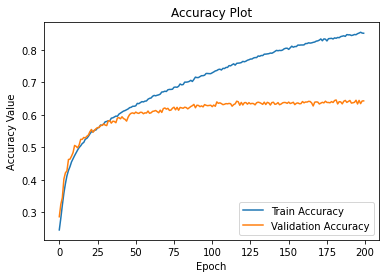

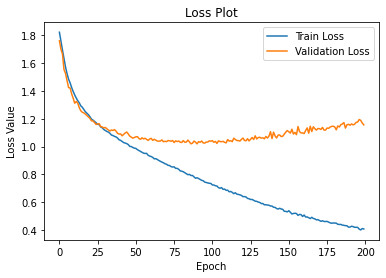

In [16]:
#Accuracy Plot
plt.plot(trainmodel.history['accuracy'], label='Train Accuracy')
plt.plot(trainmodel.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch') 
plt.legend(loc="lower right")
plt.show()
#Loss Plot
plt.plot(trainmodel.history['loss'], label='Train Loss')
plt.plot(trainmodel.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [17]:
#Convert to tf lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

#save 
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpktni2p1d/assets
